<a href="https://colab.research.google.com/github/js5972/aml_project1/blob/main/ML_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import warnings

In [109]:
model_data = pd.read_csv('model_data.csv')
model_data = model_data.drop(columns=['PMI'])

In [150]:
y_months = model_data[['STEEL_PRICE', 'YY_MM']]

Preprocessing


In [148]:
X = model_data.drop(columns=['STEEL_PRICE', 'YY_MM'])
y = model_data['STEEL_PRICE']

In [149]:
X_lagged = X.shift(1)

In [112]:
# 80 - 20 split
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=14)
print(len(train_data), len(test_data))

67 17


In [113]:
X_train = train_data.drop(columns=['STEEL_PRICE', 'YY_MM'])
y_train = train_data['STEEL_PRICE']
X_test = test_data.drop(columns=['STEEL_PRICE', 'YY_MM'])
y_test = test_data['STEEL_PRICE']

In [114]:
scaler = StandardScaler()

PCA


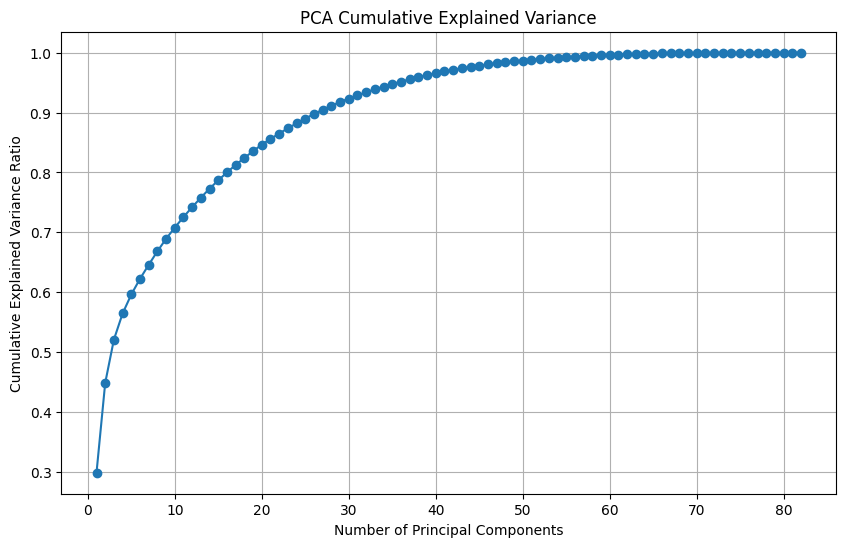

In [115]:
X_scaled = scaler.fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("PCA Cumulative Explained Variance")
plt.grid()
plt.show()

In [116]:
k = np.argmax(cum_var >= 0.9) + 1
k

27

90% of variance is explained by 27 principal components, a little more than a third of the variables.

In [117]:
# for reference, viewing the top countries of the first three components that explain about 57% variance

top_3 = pca.components_[:3]

for i, component in enumerate(top_3):
    top_indices = np.argsort(np.abs(component))[-3:][::-1]
    top_cts = np.array(X.columns)[top_indices]
    print(f"Top countries for Principal Component {i+1}: {', '.join(top_cts)}")

Top countries for Principal Component 1: GEN_VAL_MO_x_2010, GEN_VAL_MO_x_5230, GEN_VAL_MO_x_3310
Top countries for Principal Component 2: GEN_VAL_MO_x_4279, GEN_VAL_MO_x_4280, GEN_VAL_MO_x_5880
Top countries for Principal Component 3: GEN_VAL_MO_x_4890, GEN_VAL_MO_x_4792, GEN_VAL_MO_x_4370


2010 - MEXICO

5230 - OMAN

3310 - ECUADOR

4279 - FRANCE

4280 - GERMANY

5880 - JAPAN

4792 - SLOVENIA

4890 - TURKEY

3530 - PARAGUAY


Some countries seem reasonable, others less likely.

OLS REGRESSION WITH PCA

In [118]:
k = np.argmax(cum_var >= 0.9) + 1

X_pca_k = X_pca[:, :k]

ols = LinearRegression()
ols.fit(X_pca_k, y)

# sum (diff predict - actual ) *1/degrees of freedom
MSE_ols = (sum((y-ols.predict(X_pca_k))**2))/(X_pca_k.shape[0]-X_pca_k.shape[1])
var_b = MSE_ols*(np.linalg.inv(np.dot(X_pca_k.T,X_pca_k)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = ols.coef_/ sd_b
p_values = [2 * (1 - stats.t.cdf(np.abs(i), (X_pca_k.shape[0] - X_pca_k.shape[1]))) for i in ts_b]

In [119]:
print('Model Summary:')
print('MSE:', MSE_ols)
print('p-values:', p_values)
p_sig = [p for p in p_values if p < 0.05]
print('Count p-values < 0.05: ', len(p_sig))

Model Summary:
MSE: 19124.64705677864
p-values: [0.0, 0.00029826537021793165, 2.5447514295118268e-05, 0.013701634082146308, 0.010334098259199509, 0.06761708747078266, 0.48259973204609596, 0.5100142035080486, 0.0005303592578216332, 0.3591552725980227, 0.9474909429869904, 0.47581230079858106, 0.8215181447126898, 0.014587348975208192, 0.8908961629411389, 0.2935364491568697, 0.280428787075806, 0.399019614527111, 0.9233731623718455, 0.054041196586099405, 0.4291803418207738, 0.19717704604175168, 0.0955537117041183, 0.49124160332139377, 0.8441504801983191, 0.4398025777281853, 0.7075322706862313]
Count p-values < 0.05:  7


Only 8 of the beta coefficients are significant.

LASSO

In [120]:
lasso_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=14)) # group together so that scaling happens at each fold
lasso_pipeline.fit(X_train, y_train)
lasso = lasso_pipeline.named_steps['lassocv'] # get model details

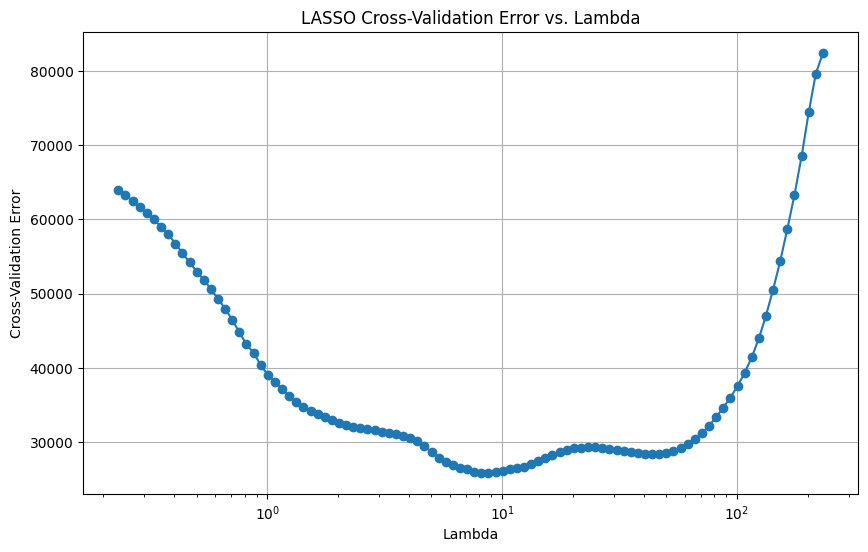

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(lasso.alphas_, lasso.mse_path_.mean(axis=1), marker='o')
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("Cross-Validation Error")
plt.title("LASSO Cross-Validation Error vs. Lambda")
plt.grid()
plt.show()

In [122]:
optimal_alpha = lasso.alpha_
zero_coef_percentage = np.mean(lasso.coef_ == 0) * 100

coef_idx = np.argsort(np.abs(lasso.coef_))[-5:][::-1]
top_cts = np.array(X_train.columns)[coef_idx]

y_pred = lasso_pipeline.predict(X_train)
MSE_lasso = mean_squared_error(y_train, y_pred)

In [123]:
print(f"Optimal alpha: {optimal_alpha}")
print(f"Coefficients set to zero: {zero_coef_percentage:.2f}%")
print(f"Top 5 influential variables: {top_cts}")
print(f"MSE: {MSE_lasso}")

Optimal alpha: 8.153926716598795
Coefficients set to zero: 64.63%
Top 5 influential variables: ['GEN_VAL_MO_x_2150' 'GEN_VAL_MO_x_4099' 'GEN_VAL_MO_x_4622'
 'GEN_VAL_MO_x_2230' 'GEN_VAL_MO_x_2470']
MSE: 7420.060421432624


2150 - HONDURAS

4099 - DENMARK

4622 - BELARUS

2230 - COSTA RICA

2470 -  DOMICAN REPUBLIC

Better performance than PCA, however completely different output. Seems somewhat random.

RIDGE

In [124]:
ridge_pipeline = make_pipeline(StandardScaler(), RidgeCV(cv=5))
ridge_pipeline.fit(X_train, y_train)
ridge = ridge_pipeline.named_steps['ridgecv']

In [125]:
optimal_alpha = ridge.alpha_

coef_idx = np.argsort(np.abs(ridge.coef_))[-5:][::-1]
top_cts = np.array(X_train.columns)[coef_idx]

y_pred = ridge_pipeline.predict(X_train)
MSE_ridge = mean_squared_error(y_train, y_pred)

In [126]:
print(f"Optimal alpha: {optimal_alpha}")
print(f"Top 5 influential variables: {top_cts}")
print(f"MSE: {MSE_ridge}")

Optimal alpha: 10.0
Top 5 influential variables: ['GEN_VAL_MO_x_4099' 'GEN_VAL_MO_x_2150' 'GEN_VAL_MO_x_2230'
 'GEN_VAL_MO_x_5820' 'GEN_VAL_MO_x_5700']
MSE: 3654.1751121530697


4099 - DENMARK

2150 - HONDURAS

2230 - COSTA RICA

5820 - HONG KONG

5700 - CHINA



Significantly lower MSE, and some overlap with Lasso.

DECISION TREES

In [127]:
tree_pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=14))

param_grid = {
    'decisiontreeregressor__max_depth': [3, 5, 10, 20, None],
    'decisiontreeregressor__min_samples_leaf': [3, 5, 10], # not fewer to prevent overfitting which seems to be a recurring issue after a couple runs
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__max_features': ['auto', 'sqrt', 'log2', None],
    'decisiontreeregressor__max_leaf_nodes': [None, 10, 20, 50],
    'decisiontreeregressor__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
}

grid_search = GridSearchCV(tree_pipeline, param_grid, cv=5) # specify parameters to prevent overfitted tree
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Optimal Parameters: {best_params}")

Optimal Parameters: {'decisiontreeregressor__criterion': 'squared_error', 'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_features': 'sqrt', 'decisiontreeregressor__max_leaf_nodes': None, 'decisiontreeregressor__min_samples_leaf': 3, 'decisiontreeregressor__min_samples_split': 2}


In [128]:
tree = grid_search.best_estimator_.named_steps['decisiontreeregressor']

feature_importance = tree.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]  # Sort by importance


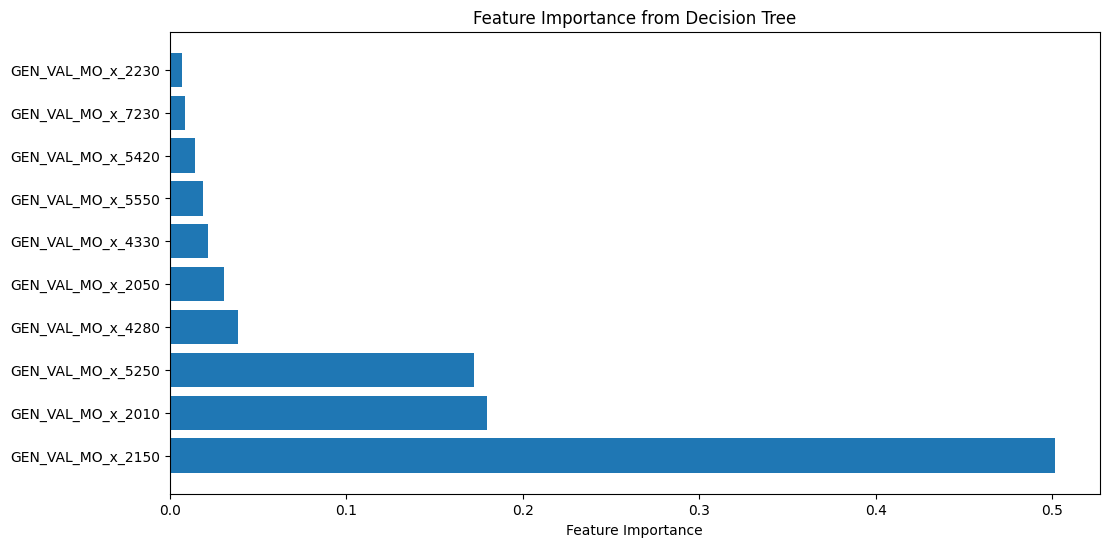

In [129]:
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[sorted_idx[:10]], feature_importance[sorted_idx[:10]], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Decision Tree')
plt.show()

2150 - HONDURAS

3310 - ECUADOR

2050 - GUATEMALA

5800 - SOUTH KOREA

4120 - UNITED KINGDOM

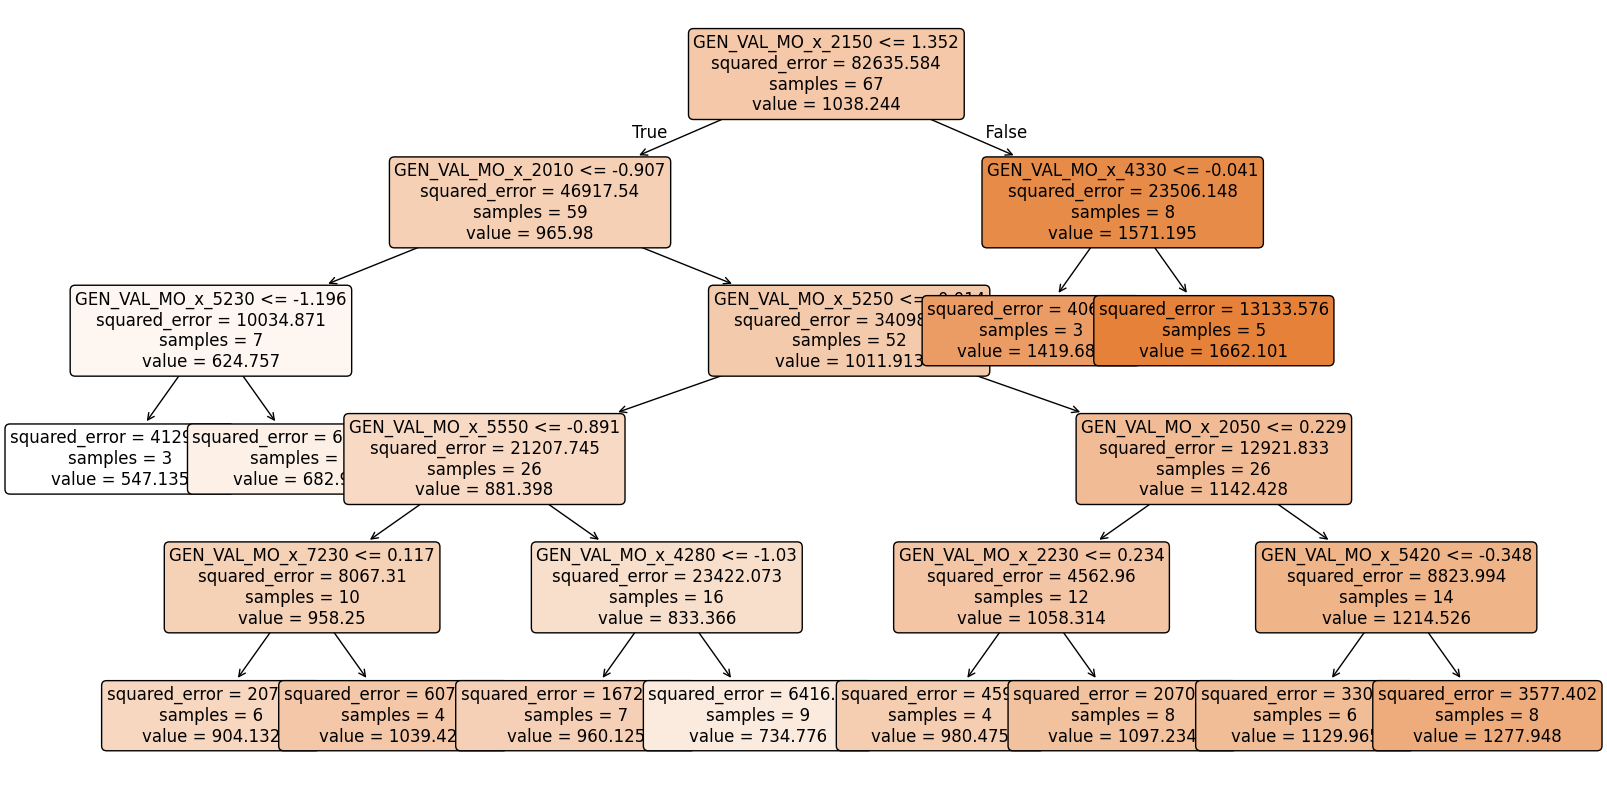

In [130]:
# Visualize tree for understanding purposes
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train.columns, rounded=True, fontsize=12)
plt.show()

In [131]:
max_depth = tree.max_depth
min_samples_leaf = tree.min_samples_leaf

y_pred = tree.predict(X_train)

MSE_tree = mean_squared_error(y_train, y_pred)

In [132]:
print(f"Max Depth: {max_depth}")
print(f"Min Samples Leaf: {min_samples_leaf}")
print(f"MSE: {MSE_tree}")

Max Depth: 5
Min Samples Leaf: 3
MSE: 471832.91732532816


Testing out the best parameters with different random states leads to completely different optimal models. Very high MSE.

The logic of the trees splits in this particular case is not very applicable to real life, and that might make it a worse model. It is more logical to think of import values as correlated with steel prices, than based on the size of import for each country.

RANDOM FOREST

In [133]:
warnings.filterwarnings("ignore")

rf_pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=14))

param_grid_rf = {
    'randomforestregressor__n_estimators': [50, 100, 200],
    'randomforestregressor__max_depth': [3, 5, 10, 20, None],
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 3, 5, 10],
    'randomforestregressor__max_features': ['auto', 'sqrt', 'log2', None],
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)


best_params_rf = grid_search_rf.best_params_
print(f"Optimal Parameters: {best_params_rf}")

rf = grid_search_rf.best_estimator_.named_steps['randomforestregressor']

feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]

print([X_train.columns[sorted_idx[i]] for i in range(5)])

y_pred = rf.predict(X_train)
MSE_rf = mean_squared_error(y_train, y_pred)

print(f"MSE: {MSE_rf}")

Optimal Parameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100}
['GEN_VAL_MO_x_5230', 'GEN_VAL_MO_x_3310', 'GEN_VAL_MO_x_4870', 'GEN_VAL_MO_x_3010', 'GEN_VAL_MO_x_2470']
MSE: 396142.97500102053


5230 - OMAN

3310 - ECUADOR

4870 - BULGARIA

3010 - COLOMBIA

2470 - DOMICAN REPUBLIC

BOOSTING

Optimal Parameters: {'gradientboostingregressor__learning_rate': 0.2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__subsample': 0.9}


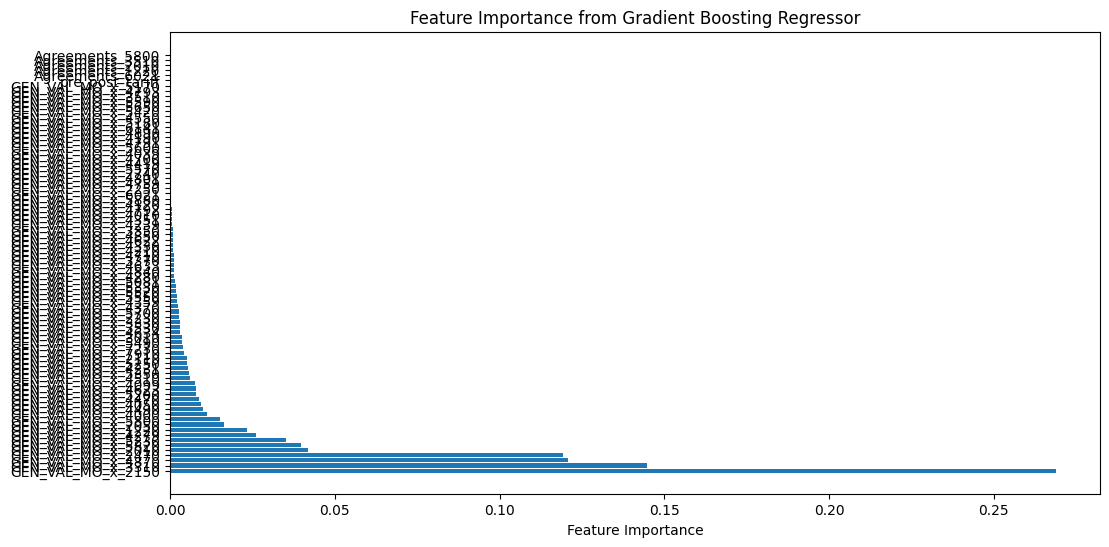

In [28]:
gbr_pipeline = make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=14))

param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 150, 200],
    'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [3, 5, 7, 10],
    'gradientboostingregressor__min_samples_split': [2, 5, 10],
    'gradientboostingregressor__min_samples_leaf': [1, 2, 5],
    'gradientboostingregressor__subsample': [0.8, 0.9, 1.0],
    'gradientboostingregressor__max_features': ['auto', 'sqrt', 'log2', None],
}

grid_search = GridSearchCV(gbr_pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Optimal Parameters: {best_params}")

best_gbr_model = grid_search.best_estimator_.named_steps['gradientboostingregressor']

feature_importance = best_gbr_model.feature_importances_
sorted_idx = feature_importance.argsort()[::-1]

plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Gradient Boosting Regressor')
plt.show()


Sorry for the horrible formatting but ran in the same cell and was to time-consuming to rerun with better axis.

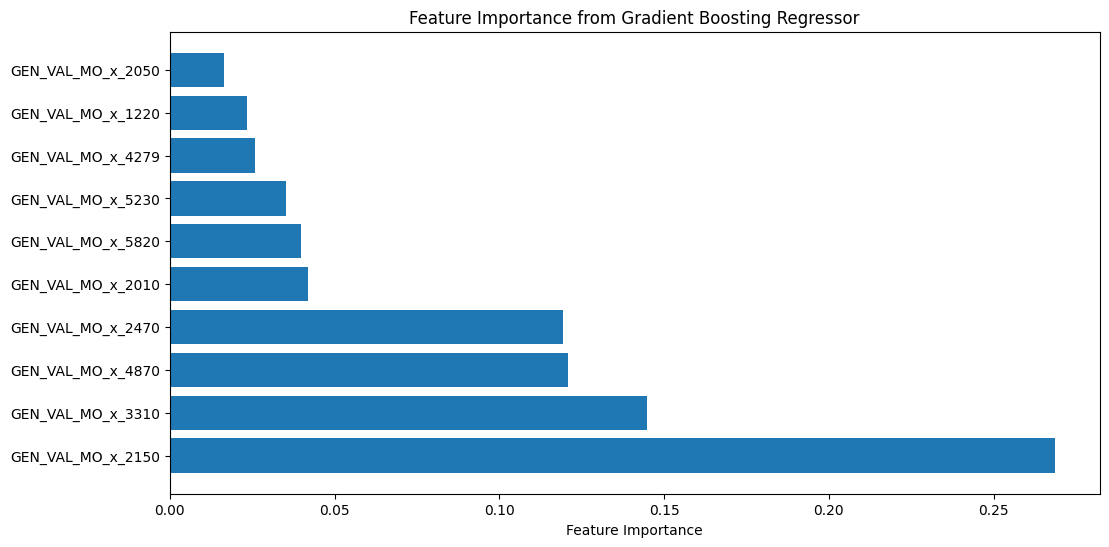

In [50]:
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[sorted_idx[:10]], feature_importance[sorted_idx[:10]], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Gradient Boosting Regressor')
plt.show()

Very clear drop in in importance after 4 countries, and outstanding importance of first country.

2150 - HONDURAS

3310 - ECUADOR

4870 - BULGARIA

2470 - DOMINICAN REPUBLIC

In [158]:
y_pred = best_gbr_model.predict(X_train)
MSE_gbr = mean_squared_error(y_train, y_pred)

print(f"MSE: {MSE_gbr}")

MSE: 586847.5675104447


MODEL SELECTION

In [159]:
print(f"MSE VALUES:")
print('OLS-PCA:', MSE_ols)
print('LASSO:', MSE_lasso)
print('RIDGE:', MSE_ridge)
print('DECISION TREE:', MSE_tree)
print('RANDOM FOREST:', MSE_rf)
print(f"GRADIENT BOOST:", MSE_gbr)

MSE VALUES:
OLS-PCA: 19124.64705677864
LASSO: 7420.060421432624
RIDGE: 3654.1751121530697
DECISION TREE: 471832.91732532816
RANDOM FOREST: 396142.97500102053
GRADIENT BOOST: 586847.5675104447


Best model: ridge

Reasoning discussed in write-up,

RANKING:
1. Ridge
2. Lasso
3. OLS-PCA
4. Random Forest
5. Decision Tree
6. Gradient Boost

MODEL TESTING

In [136]:
#scaler_test = StandardScaler()
#X_test_scaled = scaler_test.fit_transform(X_test)
y_pred = ridge_pipeline.predict(X_test)

In [137]:
X_test.shape

(17, 82)

In [138]:

MSE_test = mean_squared_error(y_test, y_pred)

print(f"Expected performance on unseen data, MSE: {MSE_test}")

Expected performance on unseen data, MSE: 52001.02271740826


Significant drop in performance form training to testing shows the model is very overfitted.

In [152]:
months = pd.date_range(start="2015-01", periods=84, freq="M")

pred_test_df = pd.DataFrame({'y_pred': y_pred, 'STEEL_PRICE': y_test})
merged_df = pd.merge(y_months, pred_test_df, on='STEEL_PRICE', how='left')



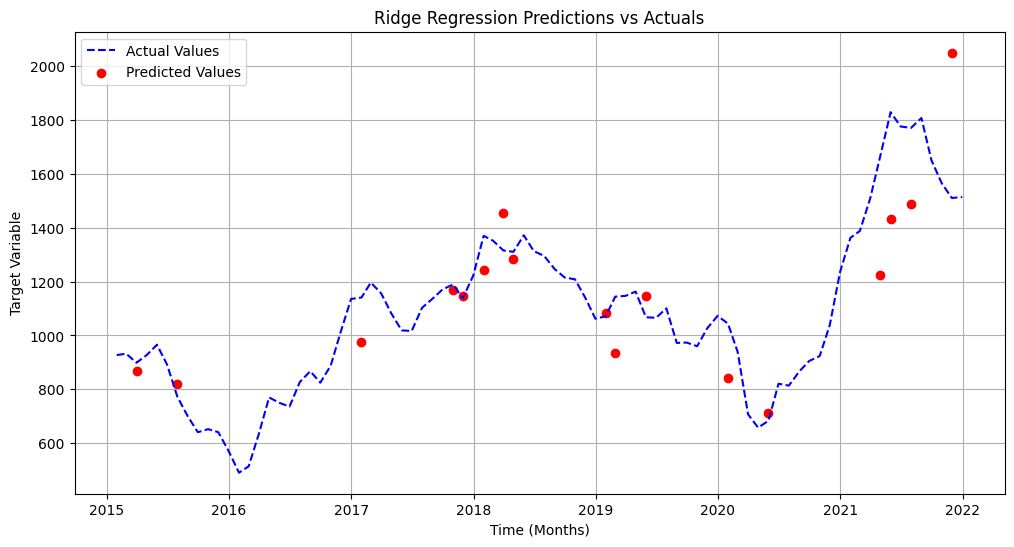

In [156]:

plt.figure(figsize=(12, 6))
plt.plot(months, y_months['STEEL_PRICE'], label="Actual Values", color="blue", linestyle="dashed")
plt.scatter(months, merged_df['y_pred'], label="Predicted Values", color="red")
plt.xlabel("Time (Months)")
plt.ylabel("Target Variable")
plt.title("Ridge Regression Predictions vs Actuals")
plt.legend()
plt.grid(True)
plt.show()